In [10]:
import os
import pandas as pd

from pyannote.core import Segment, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate
metric = DiarizationErrorRate()

In [11]:
def txt2annotation(path_txt, annotation=Annotation()):
    #check if file is txt of csv
    if path_txt.endswith('.txt'):
        with open(path_txt, 'r') as f:
            for line in f:
                if len(line) == 0:
                    continue
                start, end, speaker = line.split()
                speaker = speaker.lower()
                annotation[Segment(float(start), float(end))] = speaker
            return annotation
    elif path_txt.endswith('.csv'):
        diarization = pd.read_csv(path_txt)
        for index, row in diarization.iterrows():
            start = row['start [s]']
            end = row['end [s]']
            speaker = row['speaker']
            annotation[Segment(float(start), float(end))] = speaker
        return annotation

# Primero, una prueba sencilla

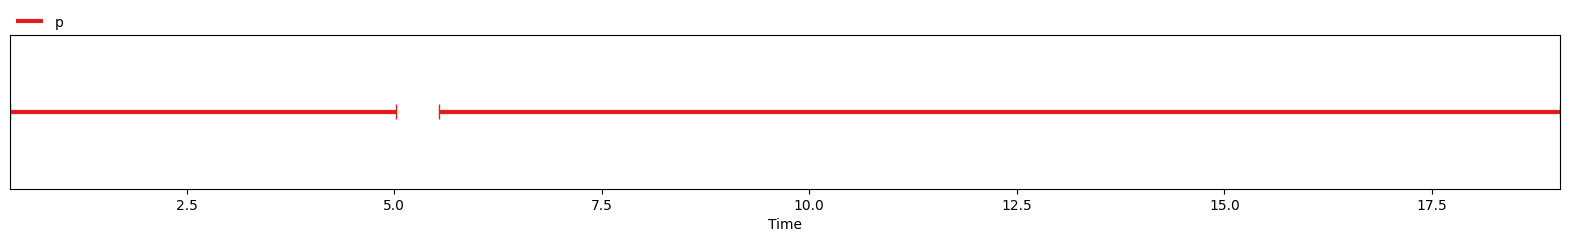

In [12]:
# reference annotation
reference_path = os.path.join('REDLAT', 'reference', 'ASW', 'REDLAT_AF111_CraftIm.txt')
reference = txt2annotation(reference_path, annotation=Annotation(uri='test'))
reference

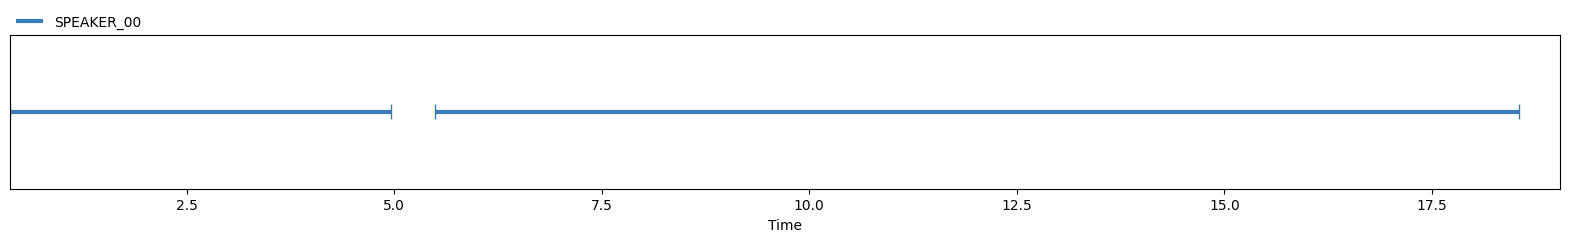

In [13]:
# hypothesis annotation
hypothesis_path = os.path.join('REDLAT', 'hypothesis', 'ASW', 'diarization', 'REDLAT_AF111_CraftIm_diarization.csv')
hypothesis = txt2annotation(hypothesis_path, annotation=Annotation(uri='test'))
hypothesis

In [14]:
# DER
metric(reference, hypothesis, detailed=True)

/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


{'confusion': 0.0,
 'missed detection': 0.5459630000000013,
 'false alarm': 0.4085310000000001,
 'total': 18.151432,
 'correct': 17.605469,
 'diarization error rate': 0.052585052242710185}

In [15]:
# full report and reset metric
report = metric.report(display=True)
metric.reset()

      diarization error rate total correct correct false alarm false alarm missed detection missed detection confusion confusion
                           %                     %                       %                                 %                   %
item                                                                                                                            
test                    5.26 18.15   17.61   96.99        0.41        2.25             0.55             3.01      0.00      0.00
TOTAL                   5.26 18.15   17.61   96.99        0.41        2.25             0.55             3.01      0.00      0.00


# Ahora obtengamos un DER para todos los pares reference - hypothesis de la base combinada

In [18]:
count = 0
# find all txt files in reference directory
reference_dir = os.path.join('REDLAT', 'reference')
reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
# os walk to find all txt files in reference directory
for root, dirs, files in os.walk(reference_dir):
        for file in files:
            if file.endswith('.txt'): 
                try:
                    reference_path = (os.path.join(root, file))
                    annotation = Annotation(uri=file)
                    # print(reference_path)
                    reference = txt2annotation(reference_path, annotation)

                    # find corresponding hypothesis file
                    hypothesis_path = reference_path.replace('reference', 'hypothesis')
                    directory, filename = os.path.split(hypothesis_path)
                    hypothesis_path = os.path.join(directory, 'diarization', filename.replace('.txt', '_diarization.csv'))
                    annotation = Annotation(uri=file)
                    hypothesis = txt2annotation(hypothesis_path, annotation)

                    # compute DER
                    metric(reference, hypothesis, detailed=True)
                except:
                    # print('Error in file:', reference_path)
                    # print(reference_path)
                    # log reference_path to file
                    with open('error_log.txt', 'a') as f:
                        f.write(reference_path)
                        f.write('\n')
                    count += 1
                    # print(count)


# cumulative report

print(abs(metric))
report = abs(metric.report(display=True))
report.to_csv('DER_report.csv')
metric.reset() # reset metric for next iteration
print('Total number of files with errors:', count)

/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and

### Rename hypothesis files in case they have the _diarized suffix

In [17]:
# # change the name of files in
# # combined_database/hypothesis/XX, deleting the suffix "_diarization"

# # find all txt files in hypothesis directory
# hypothesis_dir = os.path.join('combined_database', 'hypothesis', 'AS')
# for f in os.listdir(hypothesis_dir):
#     if f.endswith('_diarization.txt'):
#         os.rename(os.path.join(hypothesis_dir, f), os.path.join(hypothesis_dir, f.replace('_diarization', '')))